In [ ]:
!pip install -r requirements.txt

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

In [ ]:
np.random.seed(1)

# Load MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

# Model

In [12]:
LATENT_SIZE = 32
encoder = Sequential([
    Flatten(input_shape = (28, 28)),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(64),
    LR(),
    Dropout(0.5),
    Dense(LATENT_SIZE),
    LR()
])
decoder = Sequential([
    Dense(64, input_shape = (LATENT_SIZE,)),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(784),
    Activation("sigmoid"),
    Reshape((28, 28))
])
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = Model(inputs = img, outputs = output)
model.compile("nadam", loss = "binary_crossentropy")

1/1 [==============================] - 0s 16ms/step


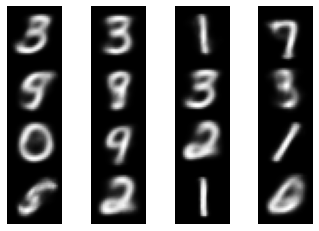

----------- EPOCH 36 -----------
 504/1875 [=======>......................] - ETA: 21s - loss: 0.1923

In [ ]:
EPOCHS = 60
#Only do plotting if you have IPython, Jupyter, or using Colab
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)